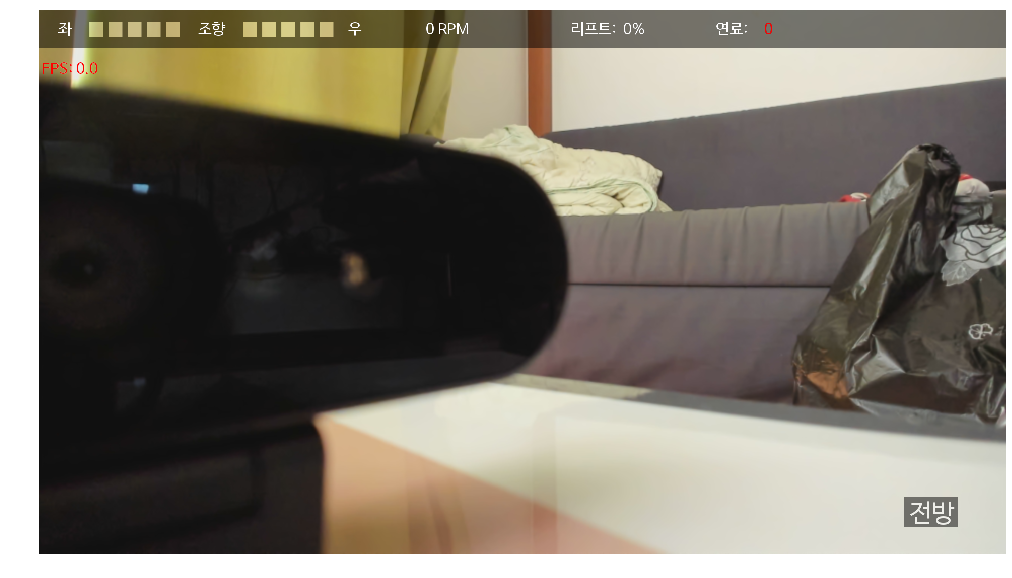

Camera Released
CAN BUS Down


In [2]:
#%%file newGUI_4k.py
%matplotlib inline

import numpy as np
import cv2
from PIL import ImageFont, ImageDraw, Image, ImageColor
import can
from threading import Thread
import time
import subprocess
import matplotlib.pyplot as plt

TXT_WHT = (255,255,255,255)
TXT_BLU = (255,0,0,255)
TXT_RED = (0,0,255,255)
TXT_GRN = (0,255,0,255)
TXT_WHT50 = (255,255,255,128)
TXT_WHT25 = (255,255,255,64)
TXT_WHT75 = (255,255,255,192)
TXT_ORG = (0,128,255,255)

# CAN MASK
# 0b0111111111110000

class multiView:
    def __init__(self, vid_num=[0, 2, 4, 6], can_chan='can0', cap_res=[1280, 720], disp_res=[3840, 2160],
                 win_n='MultiView', can_filter=[{"can_id": 0x19ffa050, "can_mask": 0x1FFFFF00, "extended": True}]):
        self.vid = vid_num
        self.can_c = can_chan
        self.vid_res = cap_res
        
        self.cap = {}
        
        self.vid_thread = None
        self.can_thread = None
        
        self.can_filter = can_filter
        self.can_data = ["", 0, 0, 0, 0, 0]
        self.can_timeout = 1
        
        self.fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
        fsize = []
        if disp_res[1] <= 1080:
            fsize = [30, 40, 50]
        if disp_res[1] > 1080 and disp_res[1] <= 1440:
            fsize = [60, 80, 100]
        if disp_res[1] > 1440:
            fsize = [120, 160, 200]
            
        self.font1 = ImageFont.truetype(self.fontpath, fsize[0])
        self.font2 = ImageFont.truetype(self.fontpath, fsize[1])
        self.font3 = ImageFont.truetype(self.fontpath, fsize[2])
        #self.font4 = ImageFont.truetype(self.fontpath, 40)
        
        self.win_name = win_n
        
        self.guiMode = 0
        self.resizing = [(int(disp_res[0]*3/4), int(disp_res[1])), 
                         (int(disp_res[0]/4),int(disp_res[1]/3))]
        self.fullsize = disp_res # size without textpart
        self.txtRes = (self.fullsize[0], 60)
        self.resM2 = (int(self.fullsize[0]/2), int(self.fullsize[1]/2))
        self.resM2blk = (self.fullsize[0], int(self.fullsize[1]/4))
        self.resGuiMode1 = (int(self.fullsize[0]/2), int(self.fullsize[1]/2))
        self.selforM1 = 0
        self.selforM2 = [0, 1]
        self.viewPoint = ["전방", "후방", "좌측", "우측"]
        #(1600,960)
        self.txPosM0 = [(int(disp_res[0]*0.65), int(disp_res[1]*0.9)), 
                        (int(disp_res[0]*0.95), int(disp_res[1]*0.29)), 
                        (int(disp_res[0]*0.95), int(disp_res[1]*0.62)), 
                        (int(disp_res[0]*0.95), int(disp_res[1]*0.95))]
        self.recPosM0 = [((int(disp_res[0]*0.645), int(disp_res[1]*0.895)),(int(disp_res[0]*0.69), int(disp_res[1]*0.945))),
                        ((int(disp_res[0]*0.945), int(disp_res[1]*0.285)),(int(disp_res[0]*0.990), int(disp_res[1]*0.325))),
                        ((int(disp_res[0]*0.945), int(disp_res[1]*0.615)),(int(disp_res[0]*0.990), int(disp_res[1]*0.655))),
                        ((int(disp_res[0]*0.945), int(disp_res[1]*0.945)),(int(disp_res[0]*0.990), int(disp_res[1]*0.985)))]
        
        self.txPosM1 = [(int(disp_res[0]*0.45), int(disp_res[1]*0.45)), 
                        (int(disp_res[0]*0.95), int(disp_res[1]*0.45)), 
                        (int(disp_res[0]*0.45), int(disp_res[1]*0.95)), 
                        (int(disp_res[0]*0.95), int(disp_res[1]*0.95)), 
                        (int(disp_res[0]*0.90), int(disp_res[1]*0.90))]        
        self.recPosM1 = [((int(disp_res[0]*0.445), int(disp_res[1]*0.445)),(int(disp_res[0]*0.490), int(disp_res[1]*0.490))),
                        ((int(disp_res[0]*0.945), int(disp_res[1]*0.445)),(int(disp_res[0]*0.990), int(disp_res[1]*0.490))),
                        ((int(disp_res[0]*0.445), int(disp_res[1]*0.945)),(int(disp_res[0]*0.490), int(disp_res[1]*0.990))),
                        ((int(disp_res[0]*0.945), int(disp_res[1]*0.945)),(int(disp_res[0]*0.990), int(disp_res[1]*0.990))),
                        ((int(disp_res[0]*0.895), int(disp_res[1]*0.895)),(int(disp_res[0]*0.950), int(disp_res[1]*0.950)))]
        
        self.txPosM2 = [(int(disp_res[0]*0.2), int(disp_res[1]*0.7)), 
                        (int(disp_res[0]*0.7), int(disp_res[1]*0.7))]
        
        
        # Calculating FPS
        self.preTime = 0
        self.fps = 0
        
        # Close flag
        self.isClose = False
        
        
        # Text position predefine
        # For steering
        initx = int(disp_res[0]*0.05)
        inity = int(disp_res[1]*0.015)
        int1 = int(disp_res[0]*0.020)
        int2 = int(disp_res[0]*0.080)
        self.stPos = {}
        self.stTxt = ["좌", "조향", "우"]
        self.stTxtPos = [(int(disp_res[0]*0.02), int(disp_res[1]*0.02)),
                        (int(disp_res[0]*0.165), int(disp_res[1]*0.02)),
                        (int(disp_res[0]*0.32), int(disp_res[1]*0.02))]
        
        for i in range(10):
            self.stPos[i] = (initx+(int1*i), inity)
            if i >= 5:
                self.stPos[i] = (initx+(int1*(i-1))+int2, inity)

        ypos = 10
        self.txtPos = [(int(disp_res[0]*0.4), int(disp_res[1]*0.02)), 
                       (int(disp_res[0]*0.55), int(disp_res[1]*0.02)), 
                       (int(disp_res[0]*0.70), int(disp_res[1]*0.02)), 
                       (int(disp_res[0]*0.75), int(disp_res[1]*0.02))]

        
        # Video frame dictionary
        self.vid_frame = {}
        # Open webcams
        #fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        for i in range(len(self.vid)):
            self.cap[i] = cv2.VideoCapture(self.vid[i])
            if self.cap[i].isOpened() is False:
                print("Error: /dev/video%d is not opened. Please check connection."%self.vid[i])
                return -1
            #self.cap[i].set(cv2.CAP_PROP_FOURCC, fourcc)
            self.cap[i].set(cv2.CAP_PROP_FRAME_WIDTH, self.vid_res[0])
            self.cap[i].set(cv2.CAP_PROP_FRAME_HEIGHT, self.vid_res[1])
            #self.cap[i].set(cv2.CAP_PROP_FPS, 60)
            
        
        

        
    def mouse_callback(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            refPt = [x, y]

            if self.guiMode == 1:
                if self.selforM1 == 0:
                    if refPt[0] < self.fullsize[0]/2 and refPt[1] < (self.fullsize[1]/2+60):
                        self.selforM1 = 1

                    elif refPt[0] >= self.fullsize[0]/2 and refPt[1] < (self.fullsize[1]/2+60):
                        self.selforM1 = 2

                    elif refPt[0] < self.fullsize[0]/2 and refPt[1] >= (self.fullsize[1]/2+60):
                        self.selforM1 = 3

                    elif refPt[0] >= self.fullsize[0]/2 and refPt[1] >= (self.fullsize[1]/2+60):
                        self.selforM1 = 4

                else: self.selforM1 = 0
                    
            elif self.guiMode == 2:
                if refPt[0] < self.fullsize[0]/2:
                    self.selforM2[0] += 1
                    
                    if self.selforM2[0] >= 4:
                        self.selforM2[0] = 0
                
                else:
                    self.selforM2[1] += 1
                    
                    if self.selforM2[1] >= 4:
                        self.selforM2[1] = 0
                        
                    

            #print(refPt, self.selforM1)


            
    def vidThreadStart(self):
        if self.vid_thread == None:
            self.vid_thread = Thread(target=self.videoShowThread)
            self.vid_thread.start()
            self.preTime = time.time()
  


    def canThreadStart(self):
        # Open CAN bus
        self.bus = can.Bus(interface='socketcan', channel=self.can_c)
        # Setting filters
        self.bus.set_filters(self.can_filter)
        if self.can_thread == None:
            self.can_thread = Thread(target=self.canReadThread)
            self.can_thread.start()

    
    
    def guiModeSet(self, vid_f):
        
        if self.guiMode == 0:
            vid_frame = {}
            
            vid_frame[0] = cv2.resize(vid_f[0], self.resizing[0])
            for i in range(1,len(vid_f)):
                vid_frame[i] = cv2.resize(vid_f[i], self.resizing[1])
                
            right_frame = np.concatenate((vid_frame[1], vid_frame[2]), axis=0)
            right_frame = np.concatenate((right_frame, vid_frame[3]), axis=0)
            return_frame = np.concatenate((vid_frame[0], right_frame), axis=1)
            
            return return_frame
        
        
        
        elif self.guiMode == 1:
            
            vid_frame = {}
            for i in range(len(vid_f)):
                vid_frame[i] = cv2.resize(vid_f[i], self.resGuiMode1)
            
            if self.selforM1 == 0:
                # Merging
                upper_frame = np.concatenate((vid_frame[0], vid_frame[1]), axis=1)
                lower_frame = np.concatenate((vid_frame[2], vid_frame[3]), axis=1)
                return_frame = np.concatenate((upper_frame, lower_frame), axis=0)
                
            elif self.selforM1 == 1:
                return_frame = cv2.resize(vid_frame[0], None, fx=2.0, fy=2.0)
                
            elif self.selforM1 == 2:
                return_frame = cv2.resize(vid_frame[1], None, fx=2.0, fy=2.0)
                
            elif self.selforM1 == 3:
                return_frame = cv2.resize(vid_frame[2], None, fx=2.0, fy=2.0)
                
            elif self.selforM1 == 4:
                return_frame = cv2.resize(vid_frame[3], None, fx=2.0, fy=2.0)
                
            return return_frame
        
        
        
        elif self.guiMode == 2:
            
            vid_frame = {}
            for i in range(len(vid_f)):
                vid_frame[i] = cv2.resize(vid_f[i], self.resM2)
                
            mid_frame = np.concatenate((vid_frame[self.selforM2[0]], vid_frame[self.selforM2[1]]), axis=1)
            sand_frame = np.zeros((self.resM2blk[1], self.resM2blk[0], 3), np.uint8)
            
            upper_frame = np.concatenate((sand_frame, mid_frame), axis=0)
            return_frame = np.concatenate((upper_frame, sand_frame), axis=0)
            
            return return_frame
        

        
    
    def textDrawing(self, frame):
        # Information Bar
        # Merging text part (upper bar)
        #text_frame = np.zeros((self.txtRes[1], self.txtRes[0], 3), np.uint8)
        #show_frame = np.concatenate((text_frame, frame), axis=0)
        show_frame = frame

        # Text

        text_list = ["%s RPM"%"{:,}".format(self.can_data[3]), "리프트:  %d%%"%self.can_data[4], "연료:", "%d"%self.can_data[5]]


        # Text Color
        fuelCol = TXT_WHT
        if (self.can_data[5] <= 20): fuelCol = TXT_RED
        else: fuelCol = TXT_WHT

        # Text Font

        # Drawing Text
        frame_pil = Image.fromarray(show_frame).convert('RGBA')
        txt_new = Image.new('RGBA', frame_pil.size, (255,255,255,0))
        d_txt = ImageDraw.Draw(txt_new)
        
        # Drawing transparent rectangles
        d_txt.rectangle(((0,0), (self.fullsize[0], self.fullsize[1]*0.07)), fill=(0,0,0,128))
        
        if self.guiMode == 0:
            for i in range(len(self.recPosM0)):
                d_txt.rectangle(self.recPosM0[i], fill=(0,0,0,128))
                
        elif self.guiMode == 1:
            if self.selforM1 == 0:
                for i in range(len(self.recPosM1)-1):
                    d_txt.rectangle(self.recPosM1[i], fill=(0,0,0,128))
            else:
                d_txt.rectangle(self.recPosM1[4], fill=(0,0,0,128))
        

        # Steering part
        s_cmap = [TXT_WHT25] * 11
        s_cmap[self.can_data[2]] = TXT_ORG
        
        for i in range(len(self.stTxt)):
            d_txt.text(self.stTxtPos[i], self.stTxt[i], font=self.font1, fill=TXT_WHT)
            
        for i in range(len(s_cmap)-1):
            d_txt.text(self.stPos[i], "█", font=self.font2, fill=s_cmap[i+1])

        
        d_txt.text(self.txtPos[0], text_list[0], font=self.font1, fill=TXT_WHT)
        d_txt.text(self.txtPos[1], text_list[1], font=self.font1, fill=TXT_WHT)
        d_txt.text(self.txtPos[2], text_list[2], font=self.font1, fill=TXT_WHT)
        d_txt.text(self.txtPos[3], text_list[3], font=self.font1, fill=fuelCol)
        d_txt.text((5, 100), "FPS: %.1f"%self.fps, font=self.font1, fill=TXT_RED)
        
        
        if self.guiMode == 0:
            for i in range(len(self.viewPoint)):
                d_txt.text(self.txPosM0[i], self.viewPoint[i], font=self.font2, fill=TXT_WHT50)
                
        
        elif self.guiMode == 1:
            if self.selforM1 == 0:
                for i in range(len(self.viewPoint)):
                    d_txt.text(self.txPosM1[i], self.viewPoint[i], font=self.font2, fill=TXT_WHT50)
            else:
                d_txt.text(self.txPosM1[4], self.viewPoint[self.selforM1-1], font=self.font3, fill=TXT_WHT50)
                
        elif self.guiMode == 2:
            d_txt.text(self.txPosM2[0], self.viewPoint[self.selforM2[0]], font=self.font3, fill=TXT_WHT50)
            d_txt.text(self.txPosM2[1], self.viewPoint[self.selforM2[1]], font=self.font3, fill=TXT_WHT50)
            
        
        frame_pil = Image.alpha_composite(frame_pil, txt_new)
        #draw = ImageDraw.Draw(frame_pil)
        #draw.text(t2Pos, text2, font=font, fill=t2Col)
        #draw.text(t3Pos, text3, font=font, fill=t3Col)

        return_frame = np.array(frame_pil)
        
        return return_frame
 


    
    def videoShowThread(self):
        #cv2.namedWindow(self.win_name, cv2.WINDOW_NORMAL)
        #cv2.setWindowProperty(self.win_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
        
        while(self.isClose==False):
            # FPS
            self.fps = 1.0/(time.time() - self.preTime)
            self.preTime = time.time()
                      
            
            for i in range(len(self.vid)):
                _, self.vid_frame[i] = self.cap[i].read()
                
            """
            _, vid_frame[0] = self.cap[0].read()
            vid_frame[1] = vid_frame[0]
            vid_frame[2] = vid_frame[0]
            vid_frame[3] = vid_frame[0]
            """
            
            total_frame = self.guiModeSet(self.vid_frame)
            #print(total_frame.shape)
           
            show_frame = self.textDrawing(total_frame)
            
            plt.figure(figsize=(20,10))
            plt.axis("off")
            plt.imshow(cv2.cvtColor(show_frame, cv2.COLOR_BGR2RGB))
            plt.show()
            
            self.isClose = True
            #cv2.imshow(self.win_name, show_frame)
            #cv2.setMouseCallback(self.win_name, self.mouse_callback)
            
            
            # Keyboard input
            # View change
            """
            if cv2.waitKey(1) & 0xFF == ord('v'):
                self.guiMode += 1
                
                if self.guiMode >= 3: self.guiMode = 0

            
            # Quit GUI
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                self.isClose = True
                break
                
            if cv2.waitKey(1) & 0xFF == ord('Q'):
                self.isClose = True
                break
            

            if cv2.getWindowProperty(self.win_name,cv2.WND_PROP_VISIBLE) < 1:
                self.isClose = True
            """
                
        # Video releasing (out of while loop)
        for i in range(len(self.vid)):
            self.cap[i].release()
            
        # Close GUI
        cv2.destroyAllWindows()
        print("Camera Released")
                

            
            
            
    def canReadThread(self):
        auto = ["Off", "경심", "견인", "위치"]
        while(self.isClose == False):
            received = self.bus.recv(self.can_timeout)
              
            if received == None:
                self.can_data = ["", 0, 0, 0, 0, 0]
            
            else:
                raw_data = received.data
                auto_idx = raw_data[0] & 0b00000011
                
                autoMode = auto[auto_idx]
                monitorMode = raw_data[0]>>5
                axleAngle = raw_data[1]
                engineRPM = raw_data[2] * 256 + raw_data[3]
                liftPos = raw_data[4]
                fuelLevel = raw_data[7]

                self.can_data = [autoMode, monitorMode, axleAngle, engineRPM, liftPos, fuelLevel]
                        
        # CAN bus closing (out of while loop)
        
        self.bus.shutdown()
        print("CAN BUS Down")


        
def main():
    
    # Webcam number (for Logitech BRIO, 1 BRIO webcam has two /dev/videoXX, use first)
    vid_num = [0, 2, 4, 6]
    #vid_num = [0]
    # CAN channel
    can_ch = "can0"
    # Video resolution from webcam
    cap_res = [1280, 720]
    # Monitor resolution
    #disp_res_byte = subprocess.Popen('xrandr | grep "\*" | cut -d" " -f4',shell=True, stdout=subprocess.PIPE).communicate()[0]
    #disp_res = [int(disp_res_byte.split(b'x')[0]), int(disp_res_byte.split(b'x')[1])]
    disp_res = [1920, 1080]
    # GUI window name
    win_n = "MultiView GUI"
    # CAN filter - CAN ID, MASK, EXTENDED
    # CAN ID input 0x19ffa050~0x19ffa05f
    can_filter=[{"can_id": 0x19ffa050, "can_mask": 0x1FFFFF00, "extended": True}]
    
    #cv2.namedWindow(win_n)
    multiV = multiView(vid_num=vid_num, can_chan=can_ch, cap_res=cap_res, 
                       disp_res=disp_res, win_n=win_n, can_filter=can_filter)

    multiV.canThreadStart()
    multiV.vidThreadStart()

    

if __name__ == '__main__':
    main()
    